In [1]:
import robot
import map
import solver
import utils
import scenarios

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

%matplotlib qt

# #https://stackoverflow.com/questions/52566756/no-module-named-graphviz-in-jupyter-notebook
# --->  $ conda install -c anaconda python-graphviz 
#       $ conda install -c anaconda pydot)
import graphviz

import gtsam
import os
from gtsam.symbol_shorthand import L, X

In [6]:
import numpy as np
import smallslam.utils.datatypes as datatypes
lm1 = datatypes.landmark(5, np.array([0,1]),np.eye(2),"pig")
lm2 = datatypes.landmark(2, np.array([1,1]),np.eye(2),"pig")

lm2 > lm1

lm2.xy

array([1, 1])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

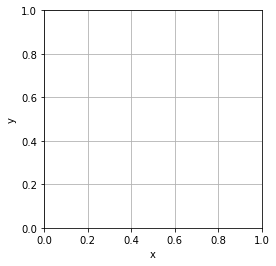

In [10]:
import smallslam.utils.plotting as plotting

plotting.spawnWorld()


# unitTest 2: Build prior map

In [2]:
np.random.seed(seed=2)

classLabels = ("table","MEP","chair","pillar","clutter")
xrange = (-2,2)
yrange = (-1,3)
sigmarange = (-0.5,0.5)

priorMap = map.map()
priorMap.fillMapRandomly(20,classLabels, xrange, yrange, sigmarange)
priorMap.plot(plotIndex = True,plotCov = True, markerSize = 30)

# unitTest 3: Plot Robot Cone

In [3]:
np.random.seed(seed=0)

#------Build worldmap
fig , ax = utils.spawnWorld(xrange = (-2,2), yrange = (-2,2))

#------Spawn Robot
pose0 = gtsam.Pose2(1.0,0.0,np.pi/2)
car = robot.robot(pose = pose0)
car.plot(ax)

#control inputs - taken from unitTest0 relative odometrey
r = 1; m = 20
dx = 0.309017 ;dy = 0.0489435; dtheta = 0.314159
gt_odom = [gtsam.Pose2(dx,dy,dtheta)] * 2*m

with plt.ion():
    for odom in gt_odom:
        car.moveAndMeasureOdometrey(odom)

        car.plot()
        plt.pause(0.1)

# unitTest 4 GTSAM

notes: </br>
examples folder: /home/alon18/LocalInstalls/miniconda3/envs/smallslam/lib/python3.9/site-packages/gtsam/examples </br>
* imuFactorISAM2Example.py - understand difference between graph.add and graph.push_back </br>
  + never mind, they are the same (?) https://gtsam.org/doxygen/a03480.html#a1bd7154e74538b5934fc616bb5ef7281 </br>
* PlanarSLAMExample.py- factor for range and bearing </br>


from VisualISAMExample.py: </br>
      # If this is the first iteration, add a prior on the first pose to set the coordinate frame </br>
        # and a prior on the first landmark to set the scale </br>

In [7]:
car, worldMap, ax, fig, gt_odom = scenarios.scenario1()
backend = solver.solver(ax = ax,X0 = car.pose ,X0cov = car.odometry_noise/1000, semantics = worldMap.exportSemantics())

#init history loggers
hist_GT, hist_DR = car.pose.translation(), car.pose.translation()

#set graphics
graphic_GT_traj, = plt.plot([], [],'ko-',markersize = 1)
graphic_DR_traj, = plt.plot([], [],'ro-',markersize = 1)

#run and plot simulation
xcurrent_DR = car.pose
with plt.ion():
    for odom in gt_odom:
        meas_odom = car.moveAndMeasureOdometrey(odom)
        meas_lms = car.measureLandmarks(worldMap)

        backend.i += 1 #increase time index. Must be done before adding measurements as factors
        backend.addOdomMeasurement(meas_odom)
        for meas_lm in meas_lms:
            backend.addlandmarkMeasurement(meas_lm)
        backend.update(N=0)

        #dead reckoning integration
        xcurrent_DR = xcurrent_DR.compose(meas_odom.dpose)
        
        #log history
        hist_GT = np.vstack([hist_GT,car.pose.translation()])
        hist_DR = np.vstack([hist_DR,xcurrent_DR.translation()])

        #plot
        car.plot()
        ax.set_title([lm.index for lm in meas_lms])
        backend.plot()

        graphic_GT_traj.set_data(hist_GT[:,0],hist_GT[:,1])
        graphic_DR_traj.set_data(hist_DR[:,0],hist_DR[:,1])
        
        plt.pause(0.1)

# Scenario 2 - 4

scenario2: linear trajectory, robot range = 10, odom_dx = 1, landmarks-yrange = (-2,+2), range = 10 </br>
scenario3: linear trajectory, robot range = 3, odom_dx = 1, landmarks-yrange = (-2,+2), range = 3 </br>
scenario4: linear trajectory, robot range = 20, odom_dx = 1, landmarks-yrange = (-10,10), range = 20 </br>

In [2]:
car, worldMap, axWorld, axError,  fig, gt_odom = scenarios.scenario4()
backend = solver.solver(ax = axWorld, X0cov = car.odometry_noise/1000, semantics = worldMap.exportSemantics())

#init history loggers
hist_GT, hist_DR, hist_ISAM2 = car.pose.translation(), car.pose.translation(), car.pose.translation()
hist_DR_error, hist_ISAM2_error = np.nan, np.nan

#set graphics
graphic_GT_traj, = axWorld.plot([], [],'ko-',markersize = 3)
graphic_DR_traj, = axWorld.plot([], [],'ro-',markersize = 3)
graphic_ISAM2_traj, = axWorld.plot([], [],'bo-',markersize = 3)
graphics_DR_error, = axError.plot([], [], 'ro-', markersize = 3)
graphics_ISAM2_error, = axError.plot([], [], 'bo-', markersize = 3)

fig.legend(handles = [graphic_GT_traj,graphic_DR_traj,graphic_ISAM2_traj], 
        labels = ["ground truth","dead reckoning","ISAM2"])

#run and plot simulation
xcurrent_DR = car.pose
with plt.ion():
    for odom in gt_odom:
        meas_odom = car.moveAndMeasureOdometrey(odom)
        meas_lms = car.measureLandmarks(worldMap)

        backend.i += 1 #increase time index. Must be done before adding measurements as factors
        backend.addOdomMeasurement(meas_odom)
        for meas_lm in meas_lms:
            backend.addlandmarkMeasurement(meas_lm)
        backend.update(N=0)

        #dead reckoning integration
        xcurrent_DR = xcurrent_DR.compose(meas_odom.dpose)

        xcurrent_ISAM2 = backend.isam2.calculateEstimatePose2(X(backend.i))

        #log history
        hist_GT = np.vstack([hist_GT,car.pose.translation()])
        hist_DR = np.vstack([hist_DR,xcurrent_DR.translation()])
        hist_ISAM2 = np.vstack([hist_ISAM2,xcurrent_ISAM2.translation()])
        hist_DR_error = np.vstack([hist_DR_error,np.linalg.norm(xcurrent_DR.translation()-car.pose.translation())])
        hist_ISAM2_error = np.vstack([hist_ISAM2_error,np.linalg.norm(xcurrent_ISAM2.translation()-car.pose.translation())])

        #plot
        car.plot()
        axWorld.set_title([lm.index for lm in meas_lms])
        backend.plot(poses = True,poses_Cov = True ,landmarks = False)

        graphic_GT_traj.set_data(hist_GT[:,0],hist_GT[:,1])
        graphic_DR_traj.set_data(hist_DR[:,0],hist_DR[:,1])
        graphic_ISAM2_traj.set_data(hist_ISAM2[:,0],hist_ISAM2[:,1])
        graphics_DR_error.set_data(range(len(hist_DR_error)),hist_DR_error)
        graphics_ISAM2_error.set_data(range(len(hist_ISAM2_error)),hist_ISAM2_error)
        axError.relim()
        axError.autoscale_view(True,True,True)

        plt.pause(0.1)

# Scenario 5 - Square

In [3]:
car, worldMap, axWorld, axError,  fig, gt_odom = scenarios.scenario5()
backend = solver.solver(ax = axWorld, X0cov = car.odometry_noise/1000, semantics = worldMap.exportSemantics())

#init history loggers
hist_GT, hist_DR, hist_ISAM2 = car.pose.translation(), car.pose.translation(), car.pose.translation()
hist_DR_error, hist_ISAM2_error = np.nan, np.nan

#set graphics
graphic_GT_traj, = axWorld.plot([], [],'ko-',markersize = 3)
graphic_DR_traj, = axWorld.plot([], [],'ro-',markersize = 3)
graphic_ISAM2_traj, = axWorld.plot([], [],'bo-',markersize = 3)
graphics_DR_error, = axError.plot([], [], 'ro-', markersize = 3)
graphics_ISAM2_error, = axError.plot([], [], 'bo-', markersize = 3)

fig.legend(handles = [graphic_GT_traj,graphic_DR_traj,graphic_ISAM2_traj], 
        labels = ["ground truth","dead reckoning","ISAM2"])

#run and plot simulation
xcurrent_DR = car.pose
with plt.ion():
    for odom in gt_odom:
        meas_odom = car.moveAndMeasureOdometrey(odom)
        meas_lms = car.measureLandmarks(worldMap)

        backend.i += 1 #increase time index. Must be done before adding measurements as factors
        backend.addOdomMeasurement(meas_odom)
        for meas_lm in meas_lms:
            backend.addlandmarkMeasurement(meas_lm)
        backend.update(N=0)

        #dead reckoning integration
        xcurrent_DR = xcurrent_DR.compose(meas_odom.dpose)

        xcurrent_ISAM2 = backend.isam2.calculateEstimatePose2(X(backend.i))

        #log history
        hist_GT = np.vstack([hist_GT,car.pose.translation()])
        hist_DR = np.vstack([hist_DR,xcurrent_DR.translation()])
        hist_ISAM2 = np.vstack([hist_ISAM2,xcurrent_ISAM2.translation()])
        hist_DR_error = np.vstack([hist_DR_error,np.linalg.norm(xcurrent_DR.translation()-car.pose.translation())])
        hist_ISAM2_error = np.vstack([hist_ISAM2_error,np.linalg.norm(xcurrent_ISAM2.translation()-car.pose.translation())])

        #plot
        car.plot()
        axWorld.set_title([lm.index for lm in meas_lms])
        backend.plot(poses = True, landmarks = False, poses_axis_length = 1.0)

        graphic_GT_traj.set_data(hist_GT[:,0],hist_GT[:,1])
        graphic_DR_traj.set_data(hist_DR[:,0],hist_DR[:,1])
        graphic_ISAM2_traj.set_data(hist_ISAM2[:,0],hist_ISAM2[:,1])
        graphics_DR_error.set_data(range(len(hist_DR_error)),hist_DR_error)
        graphics_ISAM2_error.set_data(range(len(hist_ISAM2_error)),hist_ISAM2_error)
        axError.relim()
        axError.autoscale_view(True,True,True)

        plt.pause(0.1)

# Scenario 5+ Square with Prior on LM7

In [7]:
car, worldMap, axWorld, axError,  fig, gt_odom = scenarios.scenario5()
backend = solver.solver(ax = axWorld, X0cov = car.odometry_noise/1000, semantics = worldMap.exportSemantics())
#backend.graph.remove(0)

#init history loggers
hist_GT, hist_DR, hist_ISAM2 = car.pose.translation(), car.pose.translation(), car.pose.translation()
hist_DR_error, hist_ISAM2_error = np.nan, np.nan

#set graphics
graphic_GT_traj, = axWorld.plot([], [],'ko-',markersize = 3)
graphic_DR_traj, = axWorld.plot([], [],'ro-',markersize = 3)
graphic_ISAM2_traj, = axWorld.plot([], [],'bo-',markersize = 3)
graphics_DR_error, = axError.plot([], [], 'ro-', markersize = 3)
graphics_ISAM2_error, = axError.plot([], [], 'bo-', markersize = 3)

fig.legend(handles = [graphic_GT_traj,graphic_DR_traj,graphic_ISAM2_traj], 
        labels = ["ground truth","dead reckoning","ISAM2"])

#run and plot simulation
xcurrent_DR = car.pose
with plt.ion():
    for kk, odom in enumerate(gt_odom):
        meas_odom = car.moveAndMeasureOdometrey(odom)
        meas_lms = car.measureLandmarks(worldMap)

        if kk == 20:
            backend.addlandmarkPrior(worldMap.landmarks[7])
            axWorld.set_title(f"introduced prior for lm number 7")
            plt.pause(1)

        backend.i += 1 #increase time index. Must be done before adding measurements as factors
        backend.addOdomMeasurement(meas_odom)
        for meas_lm in meas_lms:
            backend.addlandmarkMeasurement(meas_lm)
        backend.update(N=3)

        #dead reckoning integration
        xcurrent_DR = xcurrent_DR.compose(meas_odom.dpose)

        xcurrent_ISAM2 = backend.isam2.calculateEstimatePose2(X(backend.i))

        #log history
        hist_GT = np.vstack([hist_GT,car.pose.translation()])
        hist_DR = np.vstack([hist_DR,xcurrent_DR.translation()])
        hist_ISAM2 = np.vstack([hist_ISAM2,xcurrent_ISAM2.translation()])
        hist_DR_error = np.vstack([hist_DR_error,np.linalg.norm(xcurrent_DR.translation()-car.pose.translation())])
        hist_ISAM2_error = np.vstack([hist_ISAM2_error,np.linalg.norm(xcurrent_ISAM2.translation()-car.pose.translation())])

        #plot
        car.plot()
        axWorld.set_title(f"step {kk}")
        backend.plot(poses = True, landmarks = False, poses_axis_length = 1.0)

        graphic_GT_traj.set_data(hist_GT[:,0],hist_GT[:,1])
        graphic_DR_traj.set_data(hist_DR[:,0],hist_DR[:,1])
        graphic_ISAM2_traj.set_data(hist_ISAM2[:,0],hist_ISAM2[:,1])
        graphics_DR_error.set_data(range(len(hist_DR_error)),hist_DR_error)
        graphics_ISAM2_error.set_data(range(len(hist_ISAM2_error)),hist_ISAM2_error)
        axError.relim()
        axError.autoscale_view(True,True,True)

        plt.pause(0.1)

# Scenario 5+ Square with Registration To Map

In [16]:
car, worldMap, axWorld, axError,  fig, gt_odom = scenarios.scenario5()
backendX0 = gtsam.Pose2(0,5,0)
backend = solver.solver(ax = axWorld, X0 = backendX0 ,X0cov = car.odometry_noise/1000, semantics = worldMap.exportSemantics())

#init history loggers
hist_GT, hist_DR, hist_ISAM2 = car.pose.translation(), car.pose.translation(), backendX0.translation()
hist_DR_error, hist_ISAM2_error = np.nan, np.nan

#set graphics
graphic_GT_traj, = axWorld.plot([], [],'ko-',markersize = 3)
graphic_DR_traj, = axWorld.plot([], [],'ro-',markersize = 3)
graphic_ISAM2_traj, = axWorld.plot([], [],'bo-',markersize = 3)
graphics_DR_error, = axError.plot([], [], 'ro-', markersize = 3)
graphics_ISAM2_error, = axError.plot([], [], 'bo-', markersize = 3)

fig.legend(handles = [graphic_GT_traj,graphic_DR_traj,graphic_ISAM2_traj], 
        labels = ["ground truth","dead reckoning","SLAM solver"])

#run and plot simulation and provde movie
moviewriter = PillowWriter(fps = 5)
moviewriter.setup(fig,'Scenario5_Reg2Map_withFullSlamOpt.gif',dpi = 100)
xcurrent_DR = car.pose
with plt.ion():
    for kk, odom in enumerate(gt_odom):
        meas_odom = car.moveAndMeasureOdometrey(odom)
        meas_lms = car.measureLandmarks(worldMap)
            
        backend.i += 1 #increase time index. Must be done before adding measurements as factors
        backend.addOdomMeasurement(meas_odom)
        for meas_lm in meas_lms:
            backend.addlandmarkMeasurement(meas_lm)
        backend.update(N=0)

        if kk == 20:
            backend.graph.remove(0)
            backend.addlandmarkPrior(worldMap.landmarks[7])
            backend.addlandmarkPrior(worldMap.landmarks[5])
            backend.addlandmarkPrior(worldMap.landmarks[1])
            axWorld.set_title(f"registration to map: landmarks 1,5,7 \n"
                                "optimizing on full state")
            backend.optimizeFullState()

            for _ in np.arange(0.0,1.0,0.1):
                moviewriter.grab_frame()
                plt.pause(0.1)

        #dead reckoning integration
        xcurrent_DR = xcurrent_DR.compose(meas_odom.dpose)

        xcurrent_ISAM2 = backend.isam2.calculateEstimatePose2(X(backend.i))

        #log history
        hist_GT = np.vstack([hist_GT,car.pose.translation()])
        hist_DR = np.vstack([hist_DR,xcurrent_DR.translation()])
        hist_ISAM2 = np.vstack([hist_ISAM2,xcurrent_ISAM2.translation()])
        hist_DR_error = np.vstack([hist_DR_error,np.linalg.norm(xcurrent_DR.translation()-car.pose.translation())])
        hist_ISAM2_error = np.vstack([hist_ISAM2_error,np.linalg.norm(xcurrent_ISAM2.translation()-car.pose.translation())])

        #plot and update
        car.plot()
        axWorld.set_title(f"step {kk}")
        backend.plot(poses = True, landmarks = False, poses_Cov = True, poses_axis_length = 1.0)

        graphic_GT_traj.set_data(hist_GT[:,0],hist_GT[:,1])
        graphic_DR_traj.set_data(hist_DR[:,0],hist_DR[:,1])
        graphic_ISAM2_traj.set_data(hist_ISAM2[:,0],hist_ISAM2[:,1])
        graphics_DR_error.set_data(range(len(hist_DR_error)),hist_DR_error)
        graphics_ISAM2_error.set_data(range(len(hist_ISAM2_error)),hist_ISAM2_error)
        axError.relim()
        axError.autoscale_view(True,True,True)

        moviewriter.grab_frame()
        plt.pause(0.1)

#save graph as pdf in folder 
graphName = 'graph-seq5plusRegistration'
backend.graph.saveGraph(graphName) #temp file
graphviz.render('dot','pdf',graphName) #creates PDF
os.remove(graphName) #delete temp file


moviewriter.finish()

# Map from Lines